In [119]:
pip install pyhrv

     |████████████████████████████████| 3.2 MB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 230 kB 94.0 MB/s eta 0:00:01
     |████████████████████████████████| 106 kB 116.8 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 7.1 MB/s s eta 0:00:01
     |████████████████████████████████| 61.7 MB 103.2 MB/s eta 0:00:01
  Created wheel for spectrum: filename=spectrum-0.8.1-cp38-cp38-linux_x86_64.whl size=235853 sha256=a4acf3eea175564d601f4de9875f2f9fb5436e6dc6226ec8711e4d543224bd53
  Stored in directory: /home/idies/.cache/pip/wheels/8f/2c/22/4a514eb971c5f4693506f55ff7ff43fd501495322cb0b92464
  Created wheel for easydev: filename=easydev-0.12.1-py3-none-any.whl size=64200 sha256=5623ebfa3e6a9c7ed9c61f09264ec74db3028fd28ce3c1bb14b7483bad7fe946
  Stored in directory: /home/idies/.cache/pip/wheels/ed/f7/20/2b6bbee53a7f66bb264ad2bd1416f37285afab73dcec851feb
Successfully built spectrum easydev
Note: you may need to restart the kernel to use updated packages.


In [1]:
from matplotlib.figure import Figure
import json
import neurokit2 as nk
import pyarrow.parquet as pq
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import math
import biosppy
import pyhrv
import pyhrv.tools as tools
import pyhrv.time_domain as td
import pyhrv.frequency_domain as fd
import pyhrv.nonlinear as nl

In [2]:
def calc_features_helper(ecg_data):
    # calculate R peaks and NNI
    # NNI = normal to normal interval (between succesive R-peaks)
    signals, rpeaks = biosppy.signals.ecg.ecg(ecg_data, show=False, sampling_rate = 500)[1:3]
    nni = tools.nn_intervals(rpeaks)
    
    # calculate time domain, freq domain, nonlinear features all at once
    features = pyhrv.hrv(nni)
    
    # remove invalid vals
    feat = features.as_dict()
    filtered_dict = {}
    for key in feat:
        # keys that are known to produce inf or nan for our dataset
        # also remove plot/Figures
        invalid = ("fft_bands", "lomb_bands", "ar_bands", "sdnn_index", "sdann", "sampen", "dfa_alpha1", "dfa_alpha1_beats", "dfa_alpha2", "dfa_alpha2_beats", 
                   "fft_plot","nni_histogram", "lomb_plot", "ar_plot", "poincare_plot", "dfa_plot", "tachogram_plot")
        if not (key in invalid):
            filtered_dict[key] = feat[key]
            
    return filtered_dict

In [10]:
def calc_features(ecg_path):
    # ex ecg_path = "SAFE/Databases/mimic-iv-ecg-parquet/10400173/06:57:00_13_01_2128_10400173.parquet"
    # get 12-lead data from stored parquet
    ecg_raw = pq.read_table(ecg_path).to_pandas()

    # initialize pd df that'll contain features for all leads
    lead_features = {"I": calc_features_helper(pd.to_numeric(ecg_raw["I"], errors = "coerce")),
                    "II": calc_features_helper(pd.to_numeric(ecg_raw["II"], errors = "coerce")),
                    "III": calc_features_helper(pd.to_numeric(ecg_raw["III"], errors = "coerce")),
                    "aVR": calc_features_helper(pd.to_numeric(ecg_raw["aVR"], errors = "coerce")),
                    "aVL": calc_features_helper(pd.to_numeric(ecg_raw["aVL"], errors = "coerce")),
                    "aVF": calc_features_helper(pd.to_numeric(ecg_raw["aVF"], errors = "coerce")),
                    "V1": calc_features_helper(pd.to_numeric(ecg_raw["V1"], errors = "coerce")),
                    "V2": calc_features_helper(pd.to_numeric(ecg_raw["V2"], errors = "coerce")),
                    "V3": calc_features_helper(pd.to_numeric(ecg_raw["V3"], errors = "coerce")),
                    "V4": calc_features_helper(pd.to_numeric(ecg_raw["V4"], errors = "coerce")),
                    "V5": calc_features_helper(pd.to_numeric(ecg_raw["V5"], errors = "coerce")),
                    "V6": calc_features_helper(pd.to_numeric(ecg_raw["V6"], errors = "coerce"))}
    df = pd.DataFrame(lead_features)
    return df

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
nni_counter,10,10,8,10,10,10,10,10,10,10,10,10
nni_mean,448,447.8,561.375,447.9,447.5,448,447.9,447.9,447.8,447.9,447.9,447.9
nni_min,329,328,328,328,326,329,328,328,329,328,328,329
nni_max,783,784,984,784,785,783,783,783,784,784,783,783
hr_mean,142.667,142.808,129.489,142.768,142.948,142.668,142.685,142.716,142.803,142.762,142.722,142.721
hr_min,76.6284,76.5306,60.9756,76.5306,76.4331,76.6284,76.6284,76.6284,76.5306,76.5306,76.6284,76.6284
hr_max,182.371,182.927,182.927,182.927,184.049,182.371,182.927,182.927,182.371,182.927,182.927,182.371
hr_std,32.9184,33.0751,52.9082,33.0631,33.2005,32.905,32.8878,32.9514,33.0477,33.0453,32.9648,32.9551
nni_diff_mean,160.556,161.556,382.714,161.667,162,160.444,160.222,160.778,161.444,161.222,161.222,161
nni_diff_min,7,8,7,8,11,7,9,9,7,8,9,7


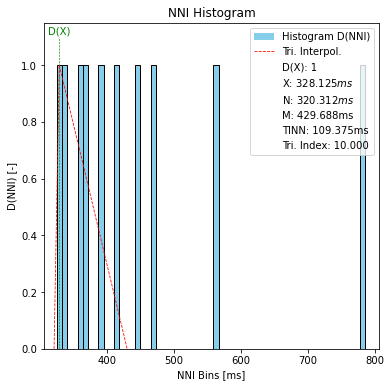

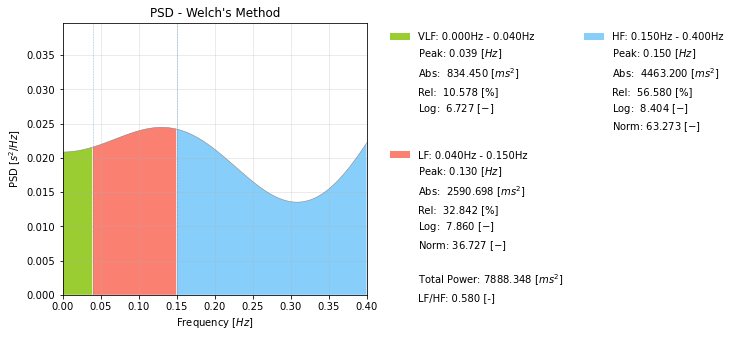

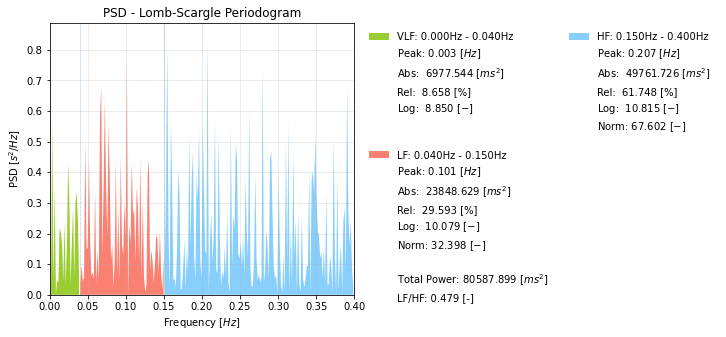

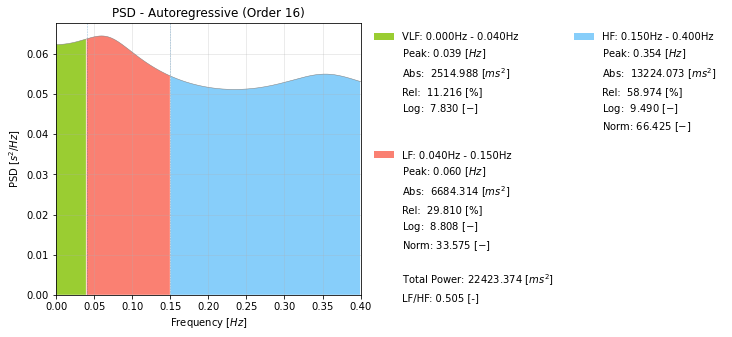

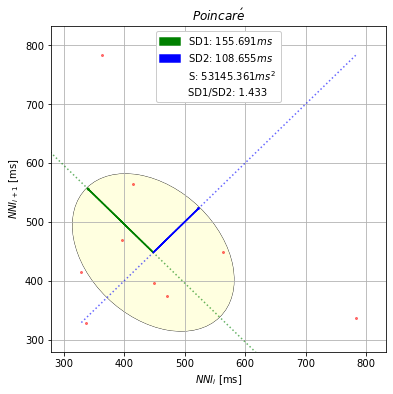

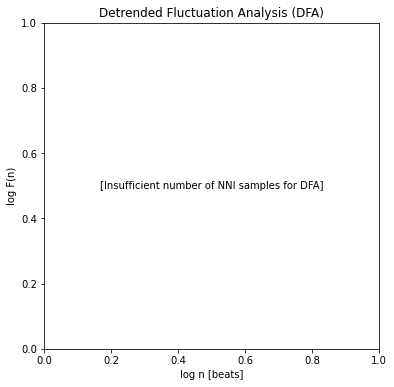

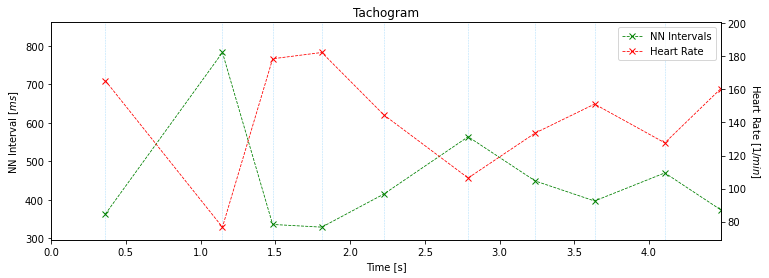

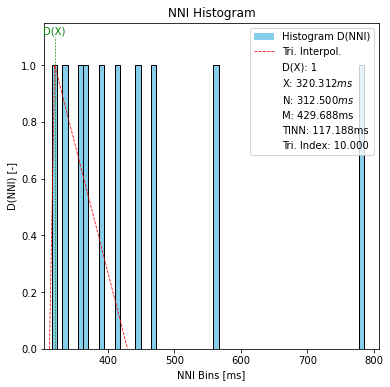

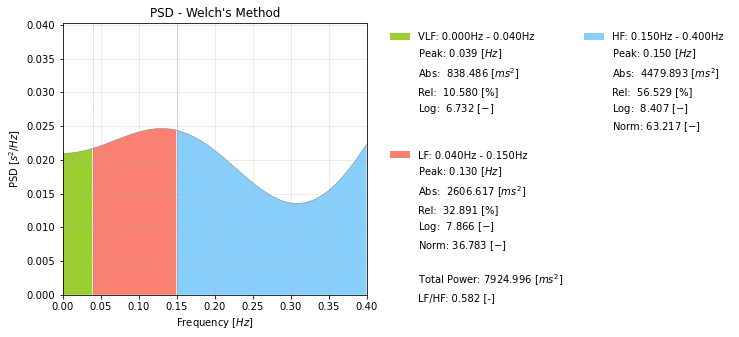

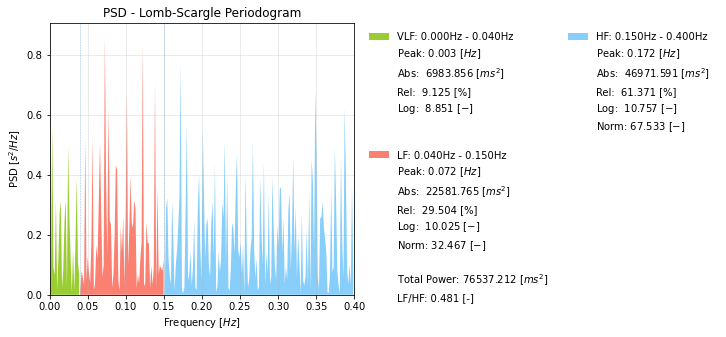

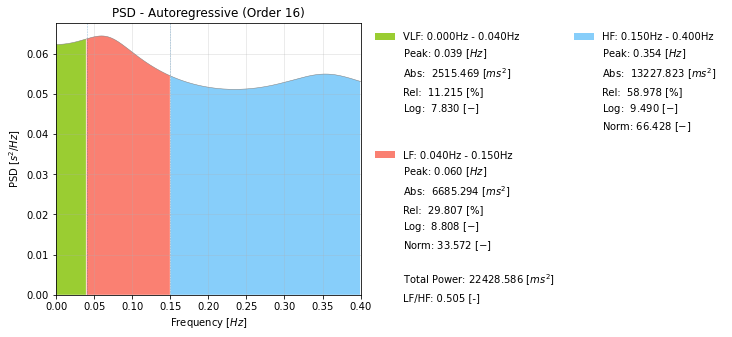

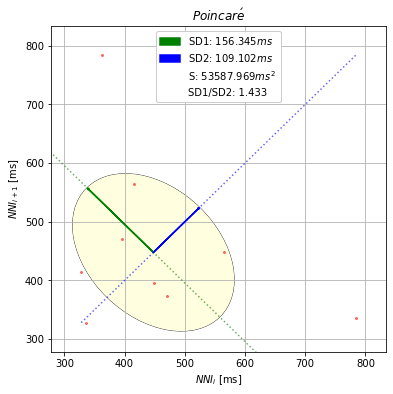

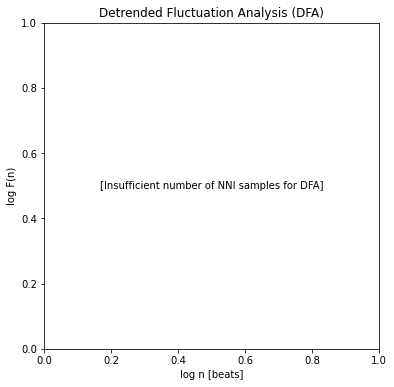

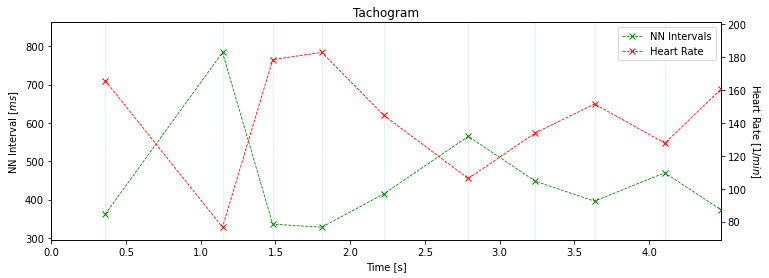

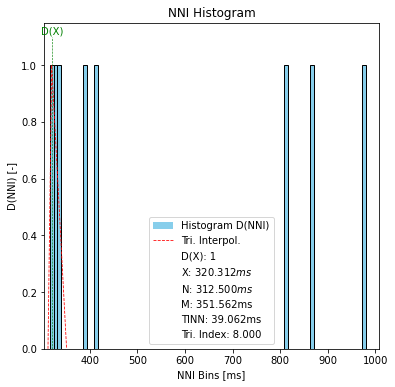

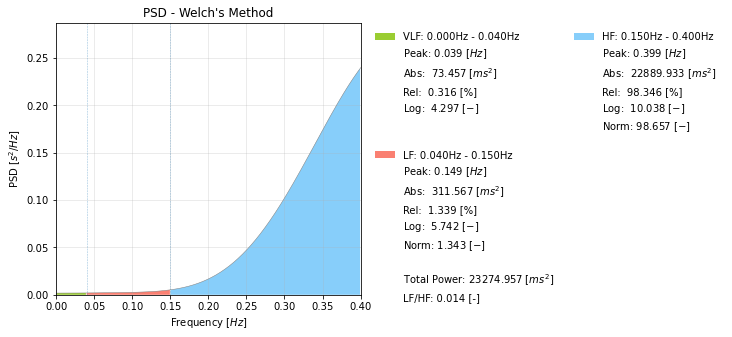

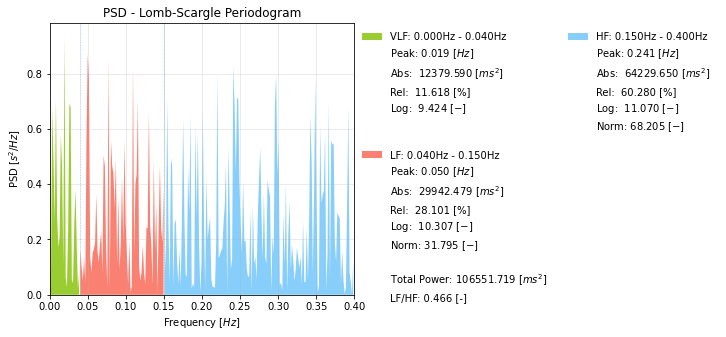

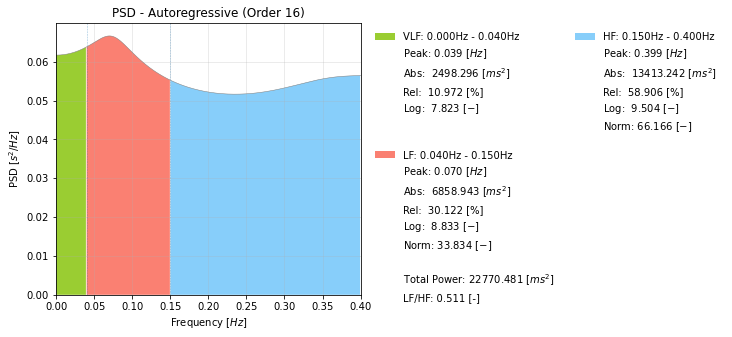

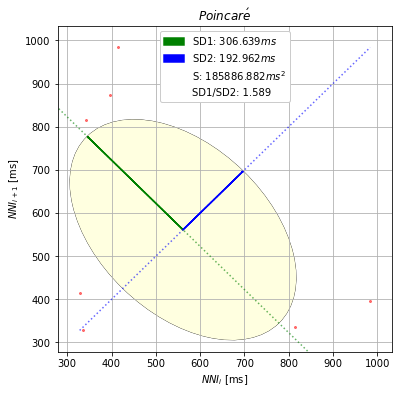

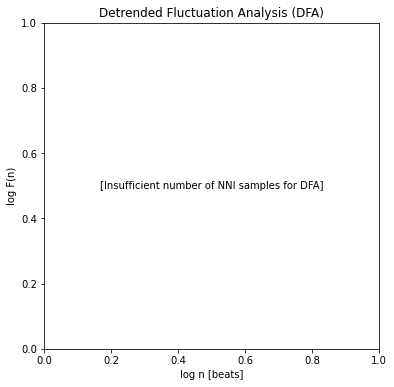

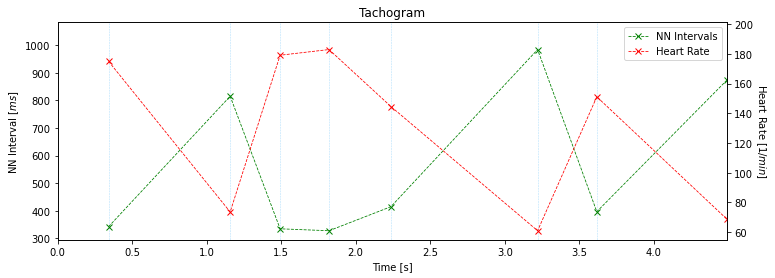

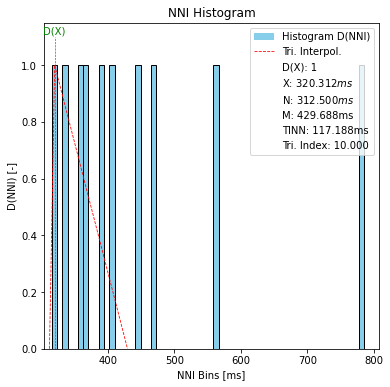

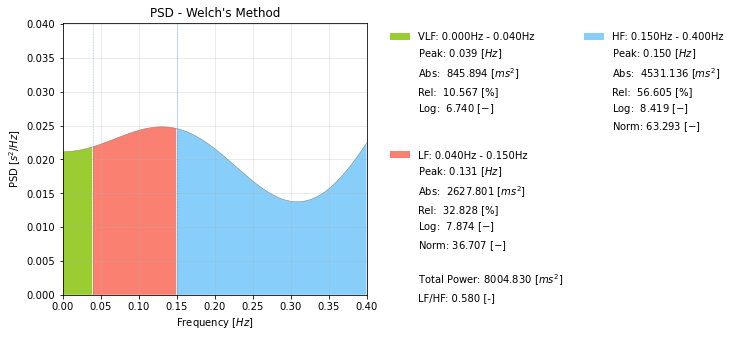

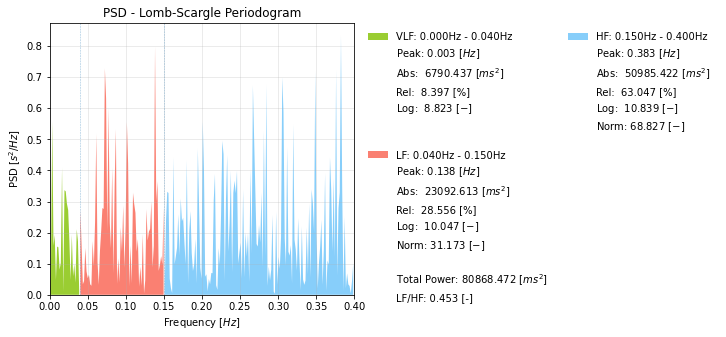

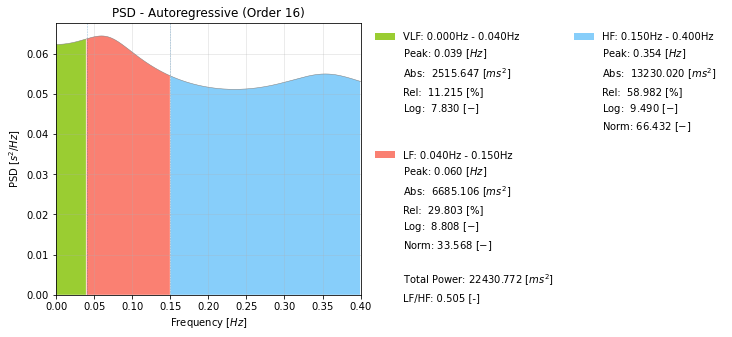

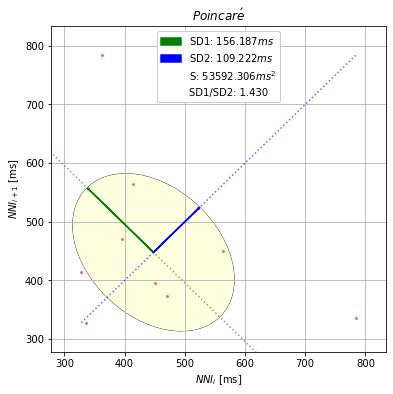

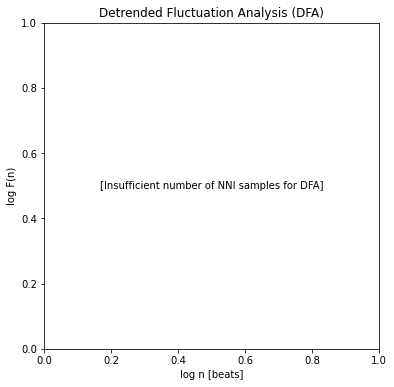

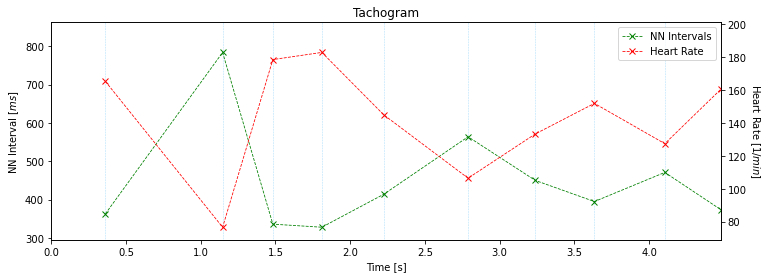

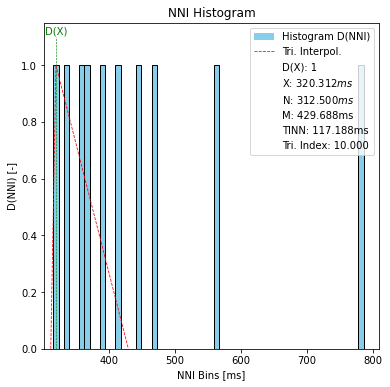

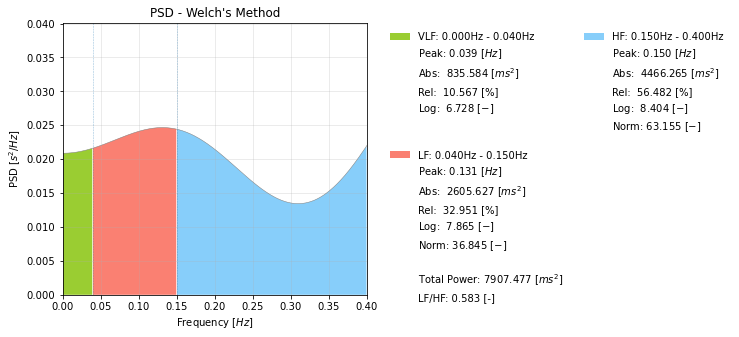

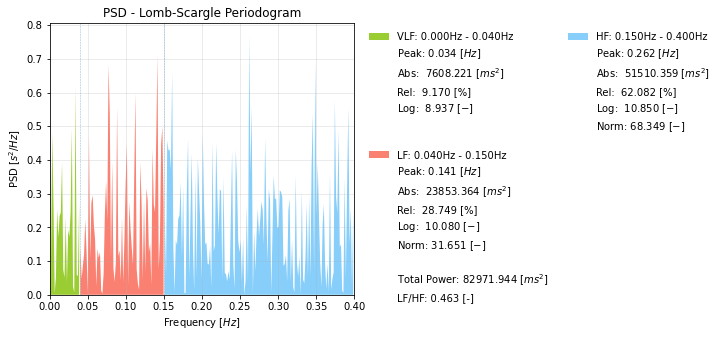

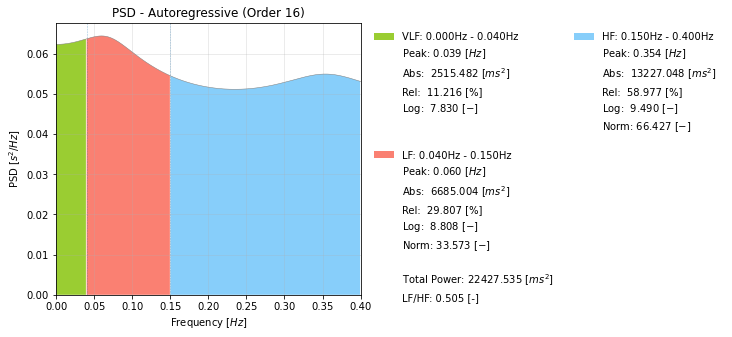

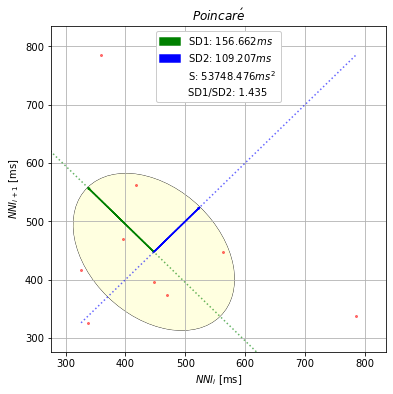

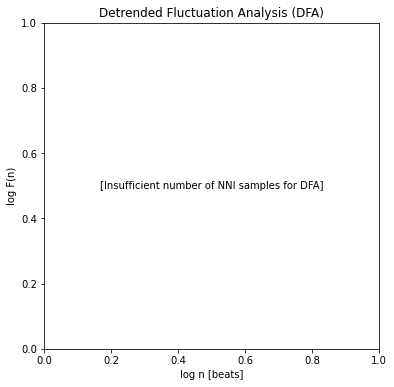

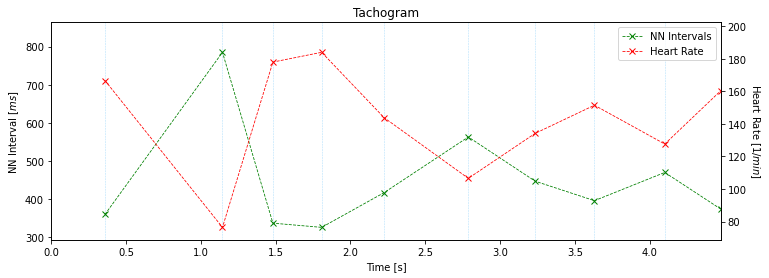

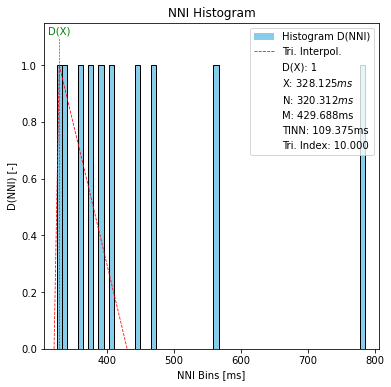

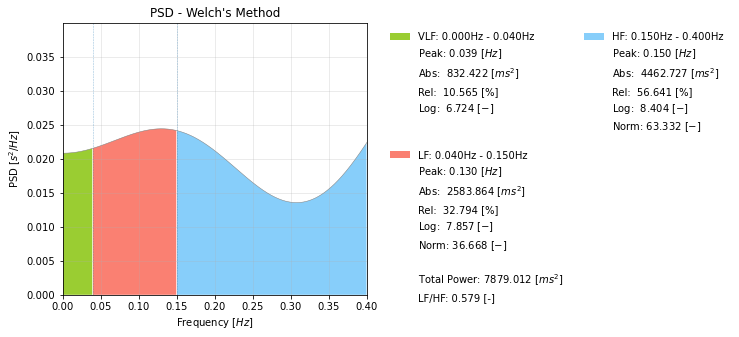

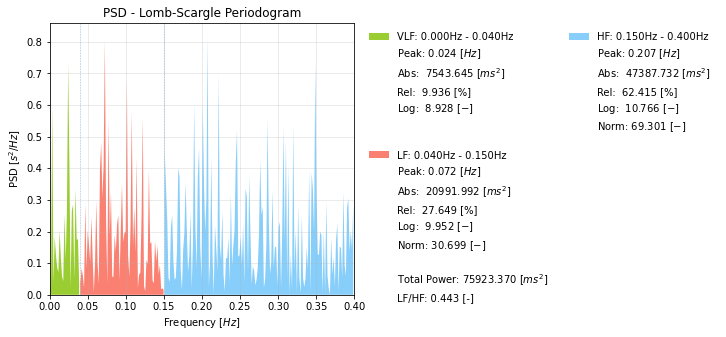

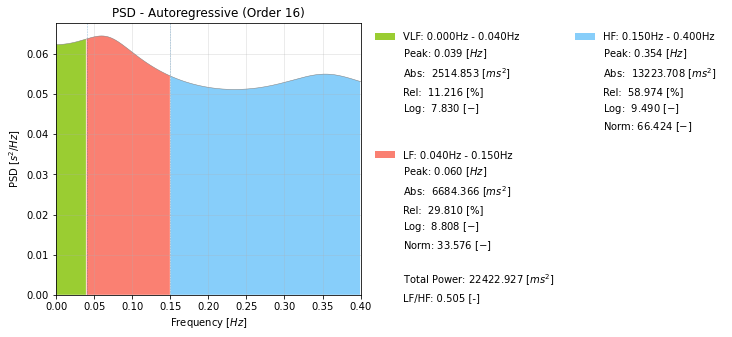

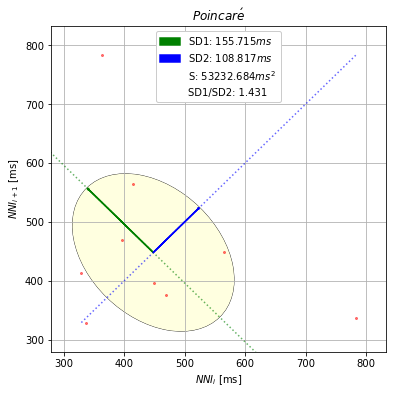

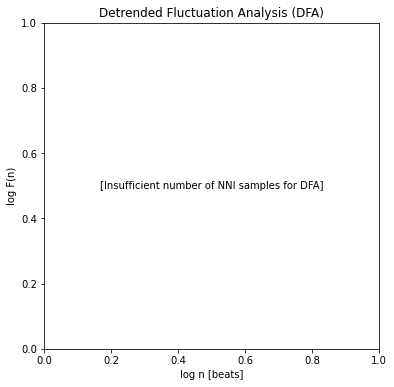

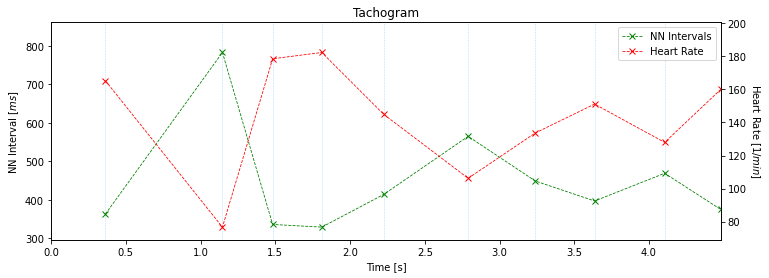

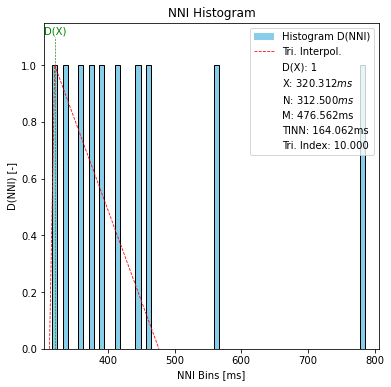

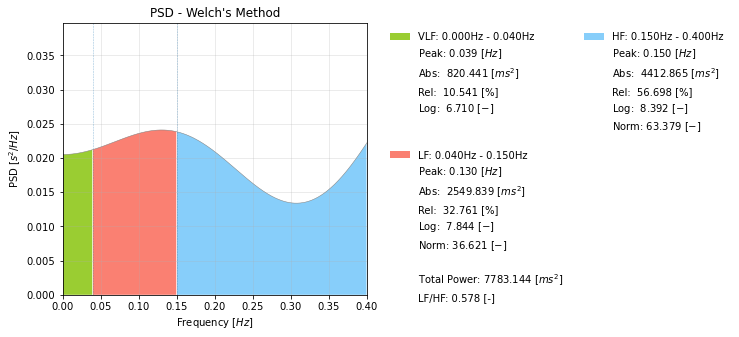

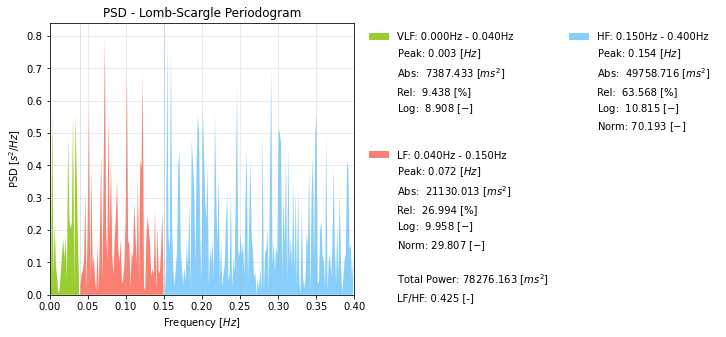

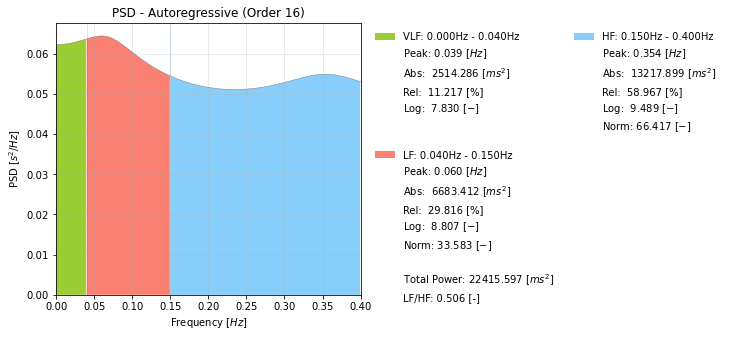

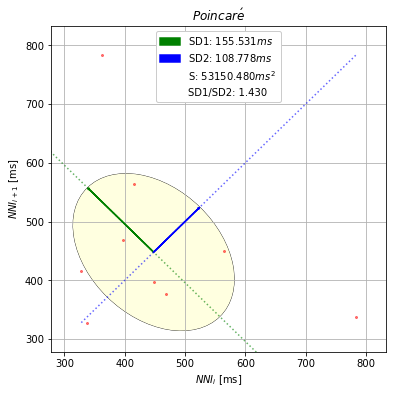

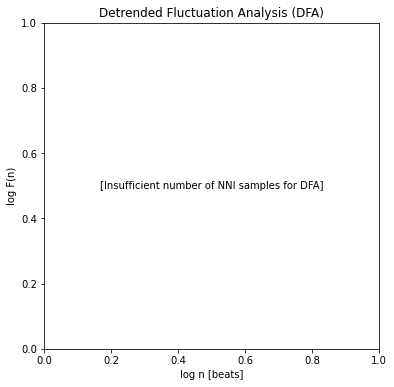

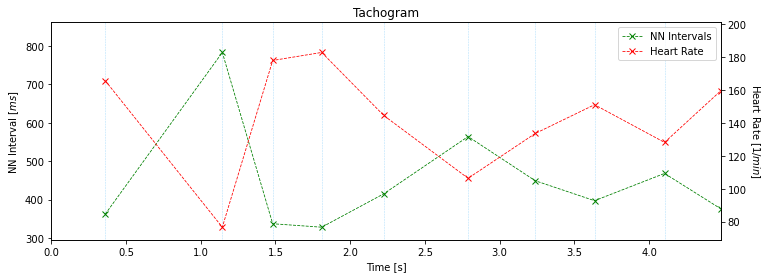

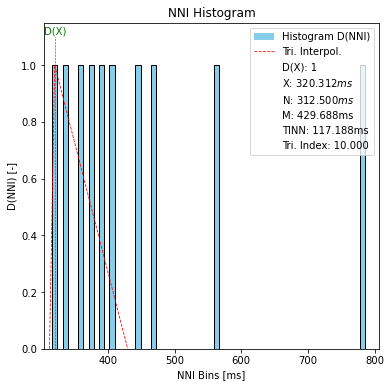

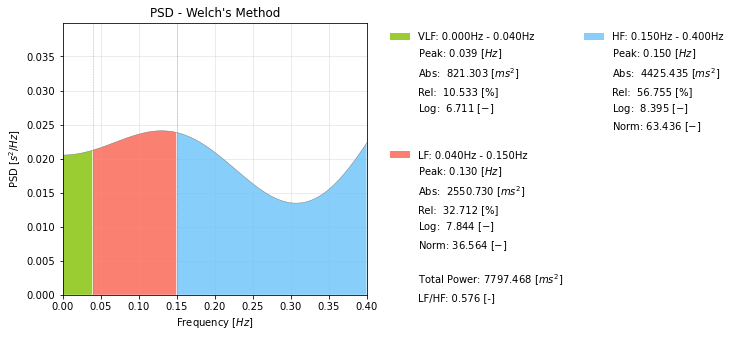

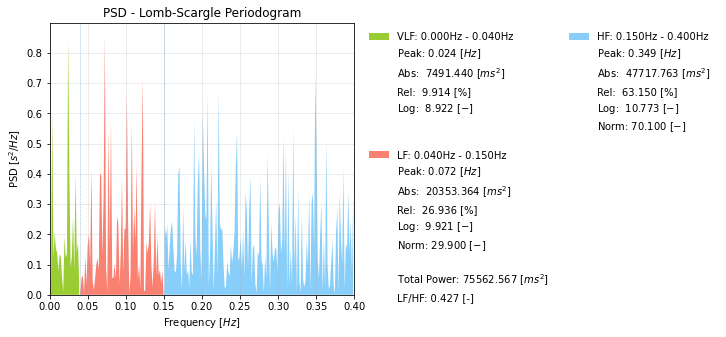

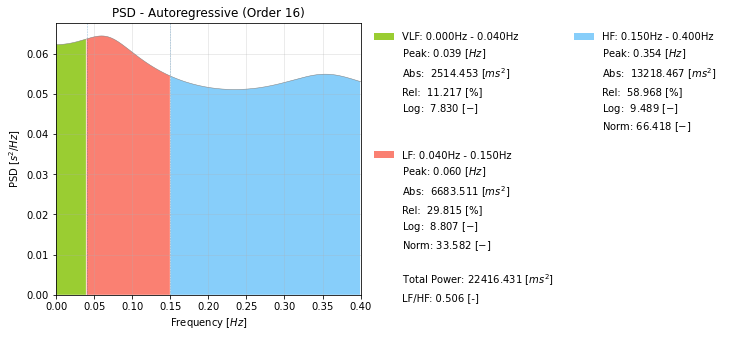

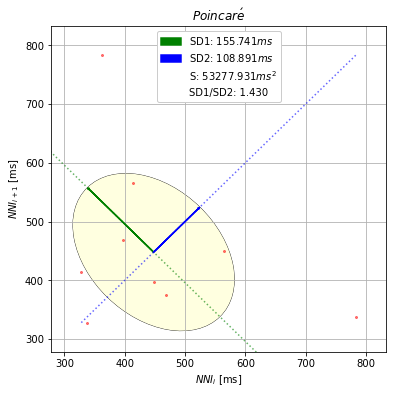

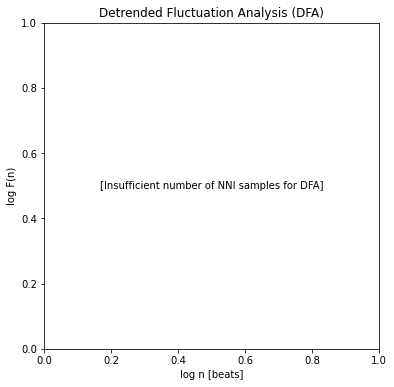

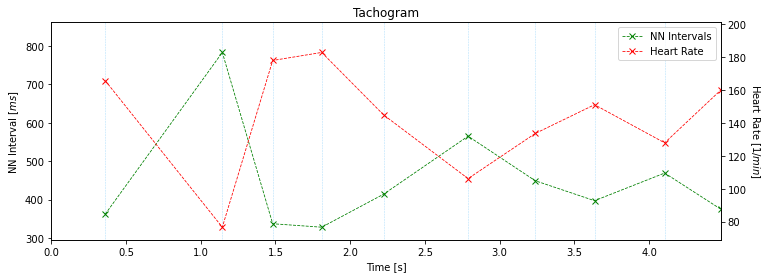

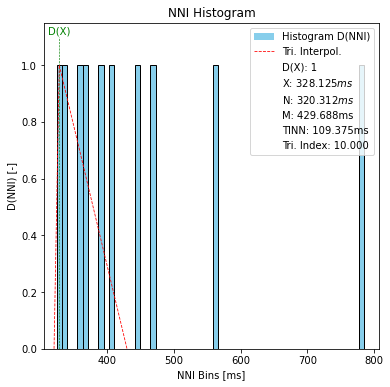

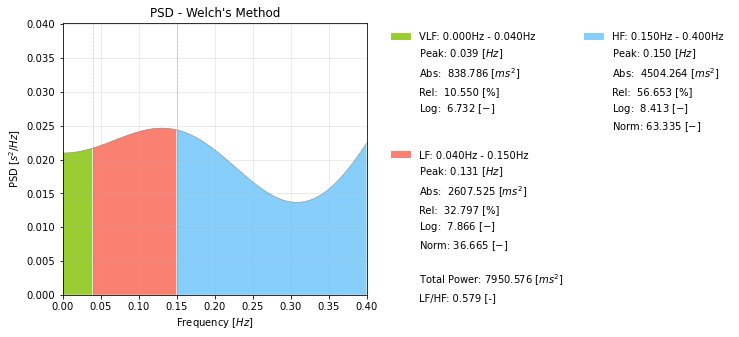

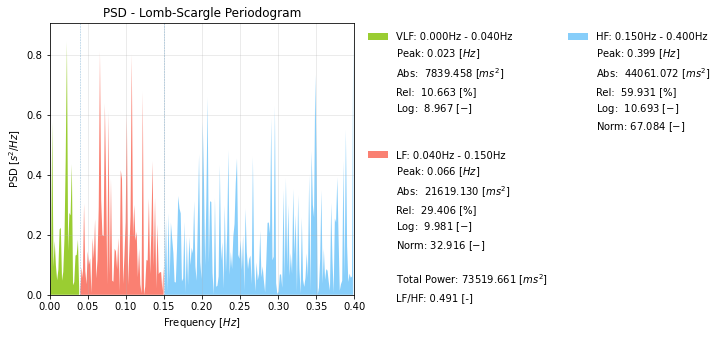

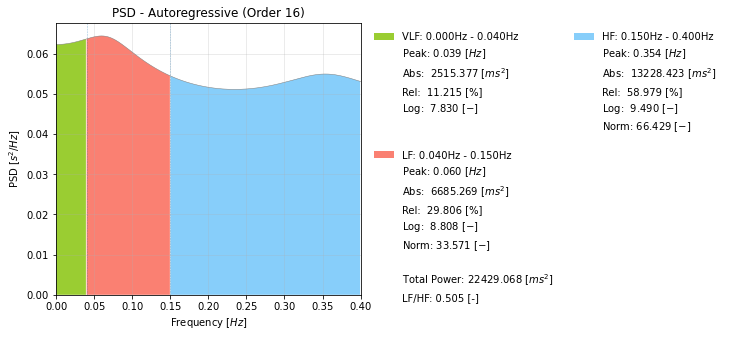

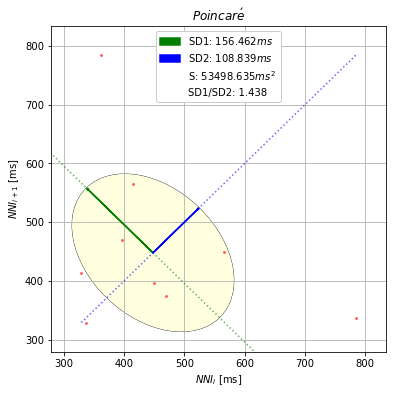

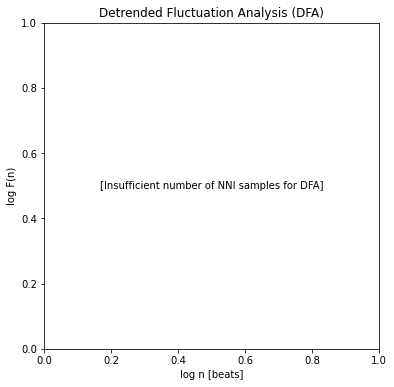

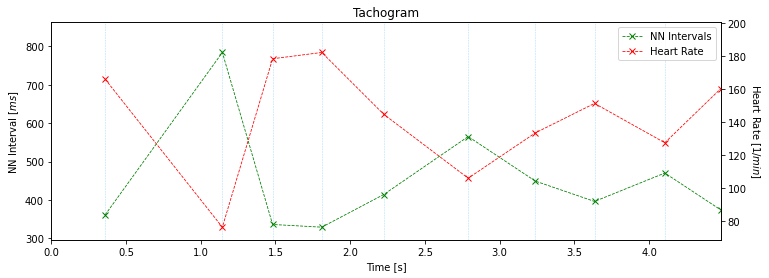

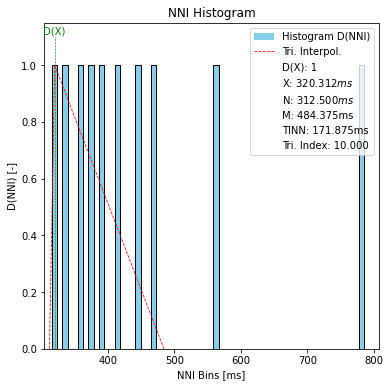

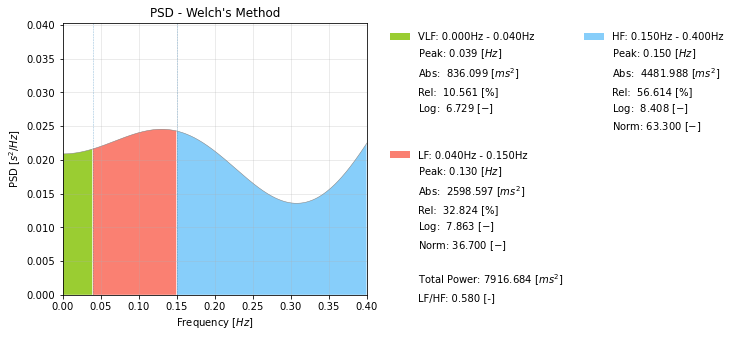

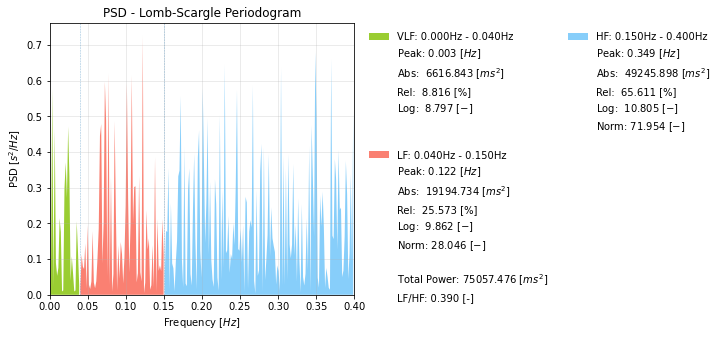

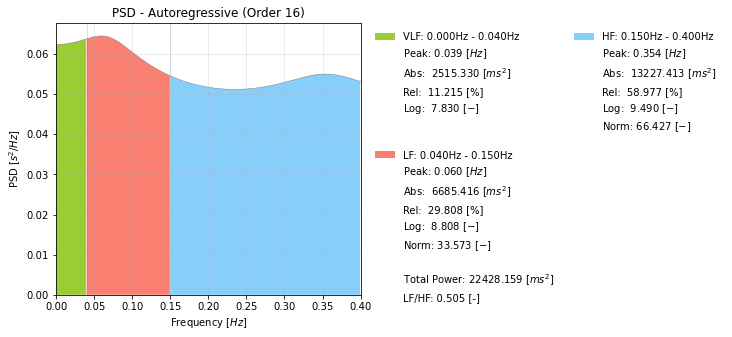

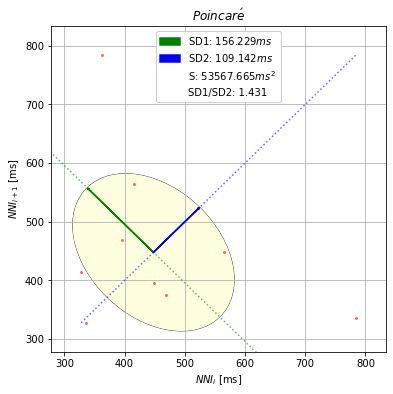

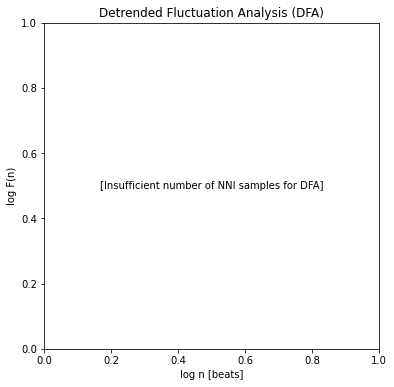

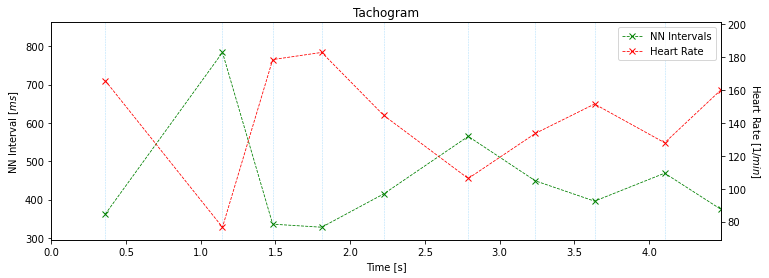

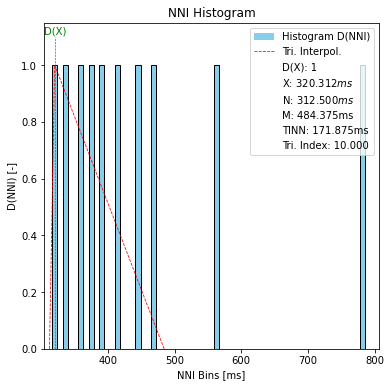

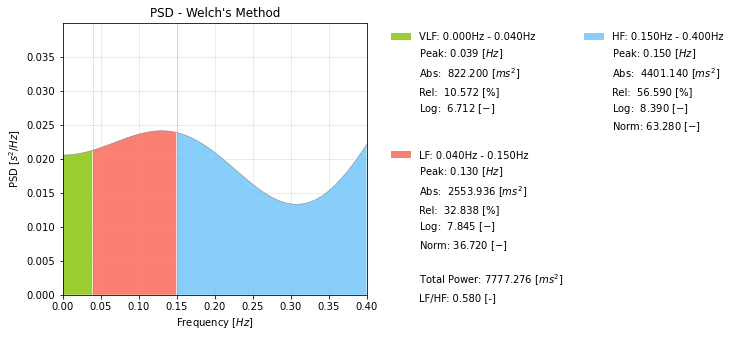

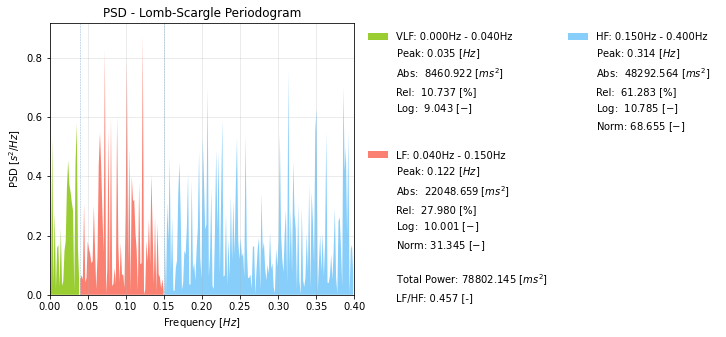

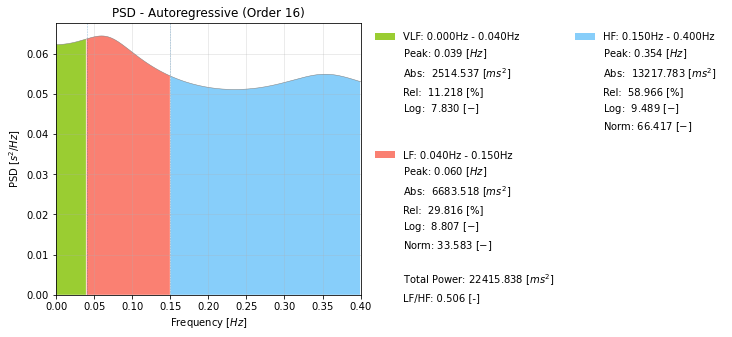

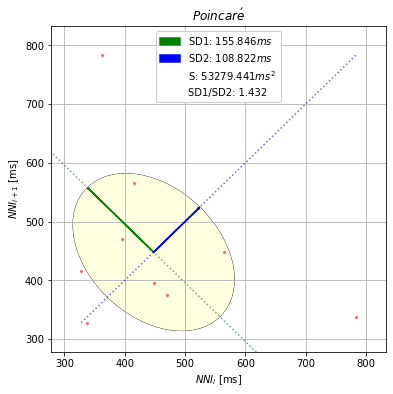

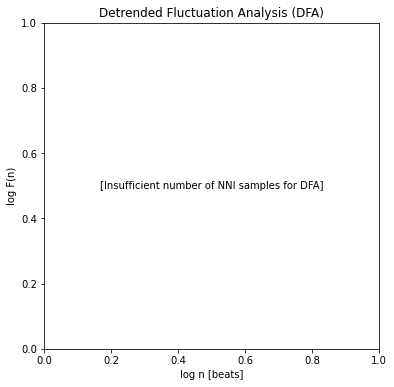

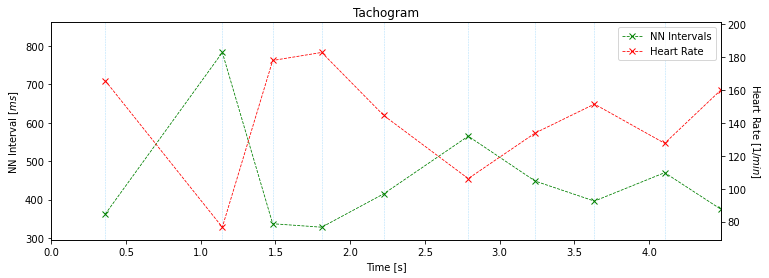

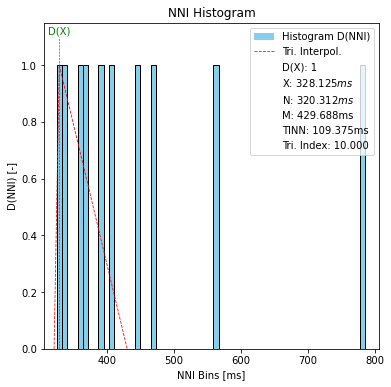

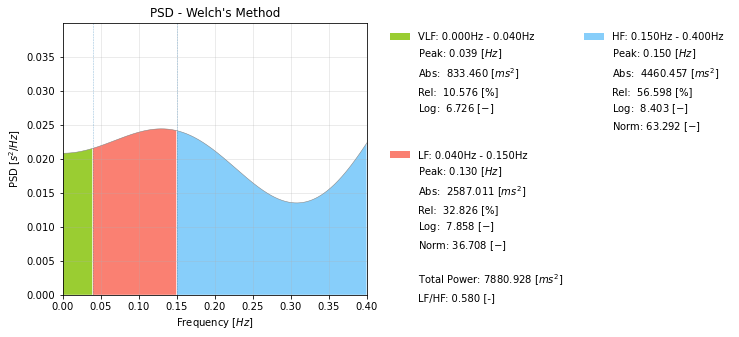

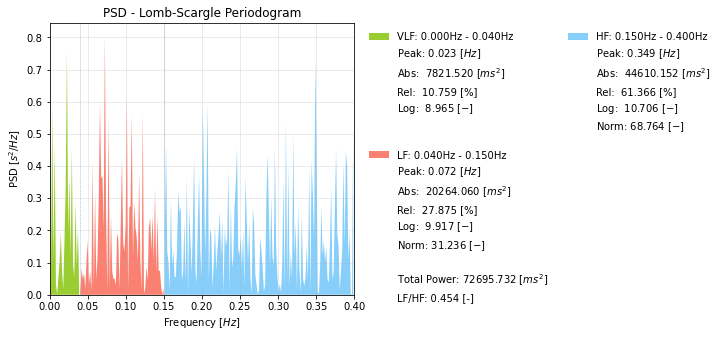

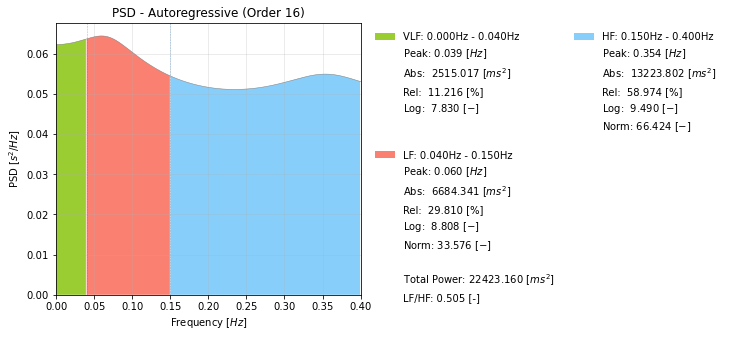

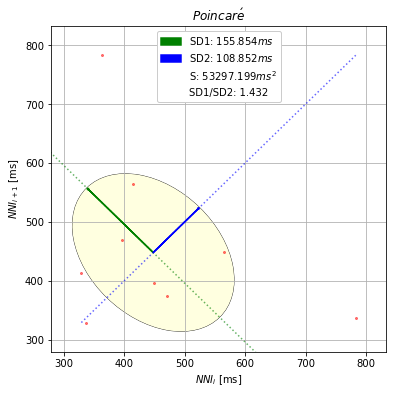

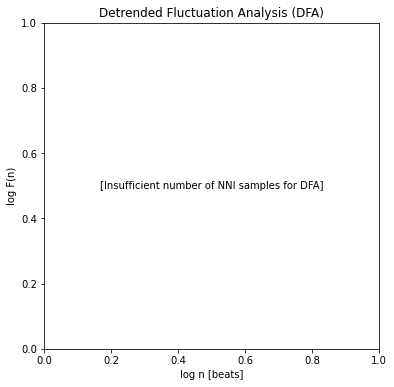

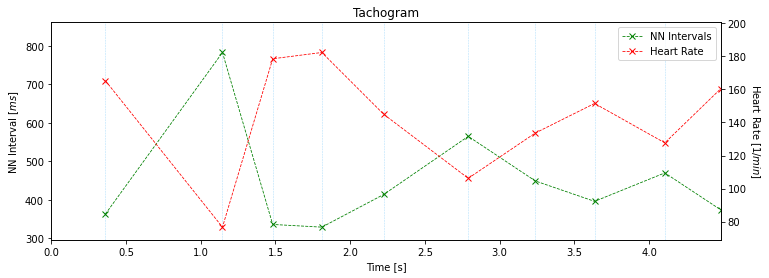

In [11]:
# ignoring the warnings that get generated from features that aren't being used in our model
import warnings
warnings.filterwarnings("ignore")
calc_features("SAFE/Databases/mimic-iv-ecg-parquet/10400173/06:57:00_13_01_2128_10400173.parquet")


[ 0.075  0.065  0.055 ... -0.02  -0.025 -0.025]


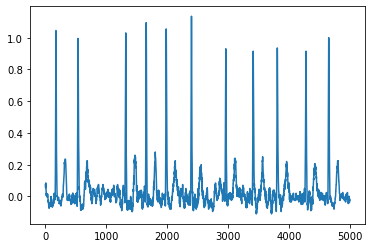

In [27]:
# sanityabove ecg lead visualized
ecg_path = "SAFE/Databases/mimic-iv-ecg-parquet/10400173/06:57:00_13_01_2128_10400173.parquet"
record = wfdb.rdrecord("SAFE/Databases/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/files/p1040/p10400173/s43577400/43577400")
lead = record.p_signal[:, record.sig_name.index("I")]
print(lead)
plt.plot(lead)
plt.show()